# LinkedIn Transition Analysis - Data Analytics (n=100)

**Objective:** Identify common job transitions within Data Analytics over the past 2–3 years using a sample of 100 public LinkedIn profiles.

**Deliverables**
- Cleaned dataset (CSV)
- Transition matrix + visualizations (incl. Sankey)
- 1-page insight summary (PDF)

**Notes**
- Data collected manually from public profile information.
- Experience level is inferred from standardized job titles via rule-based classification.

## 1. Environment Setup

This section initializes required libraries for data processing, visualization, and modeling.

Libraries used:
- pandas / numpy → data manipulation
- seaborn / matplotlib → static visualizations
- plotly → interactive Sankey diagram

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

import matplotlib.pyplot as plt
import plotly.graph_objects as go

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 80)

## 2. Data Loading

We load the manually collected dataset of 100 LinkedIn profiles.
The dataset contains previous role, current role, company, industry, location, and transition year.

In [2]:
CSV_PATH = "linkedin_transitions_template.csv" 

df_raw = pd.read_csv(CSV_PATH, encoding="latin-1")
print("Shape:", df_raw.shape)
df_raw.head(10)

Shape: (100, 8)


,profile_id,previous_title,current_title,previous_company,current_company,industry,location,transition_year
0,1,Software Engineering Analyst,Data Analyst,Accenture Federal Services,Moneta,Data Analytics,"Missouri, MO",2024.0
1,2,Student Data Scientist,Senior Data Analyst,Cox Communications,The Home Depot,Data Analytics,"Atlanta, GA",2022.0
2,3,Data Analyst Intern,Data Analyst,Wisers Informtion Limited,Merchants Bank IN,Data Analytics,NaN,2024.0
3,4,Data Analyst,Senior Analyst,Premier Logistics S.A,Independent Purchasing Cooperative,Data Analytics,"Miami, FL",2023.0
4,5,Reading Program Mentee,Data Analyst,UC Santa Barbara,"HR Unlimited, Inc",Data Analytics,"California, CA",2024.0
5,6,Leader Student-Worker,Data Analyst,Lyon College,Washington University,Data Analytics,"Missouri, MO",2023.0
6,7,BI & Strategy Intern,Data Analyst,AXS,Nuvocargo,Data Analytics,"Ciudad de Mxico, MX",2025.0
7,8,Data Analyst,Data Analyst,Dixon Resources Unlimited,"KiwiCo, Inc",Data Analytics,"California, CA",2025.0
8,9,Big Data Analyst,Data Analyst,Cognizant,Eli Lilly and Company,Data Analytics,"New Jersey, NJ",2025.0
9,10,Teaching Assistant,Data Analyst,San Diego State University,Realty Income Corporation,Data Analytics,"San Diego, CA",2025.0


**Initial Observations**

- Dataset contains 100 records and 8 core variables.
- Fields appear structurally consistent.
- Location and transition year will require minor cleaning.

## 3. Data Cleaning

To ensure analytical consistency:

- Remove incomplete records
- Standardize job titles
- Prepare fields required for transition analysis

In [3]:
def clean_text(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)
    return x

TITLE_REPLACEMENTS = [
    (r"\bSr\.?\b", "Senior"),
    (r"\bJr\.?\b", "Junior"),
    (r"\bBI\b", "Business Intelligence"),
    (r"\bAnalyst II\b", "Analyst"),
    (r"\bAnalyst III\b", "Analyst"),
]

def standardize_title(title):
    if pd.isna(title):
        return np.nan
    t = clean_text(title)
    for pattern, repl in TITLE_REPLACEMENTS:
        t = re.sub(pattern, repl, t, flags=re.IGNORECASE)
    return t.title()

def standardize_company(company):
    if pd.isna(company):
        return np.nan
    c = clean_text(company)
    c = re.sub(r",?\s+(Inc|Llc|Ltd|Limited|Gmbh)\.?\b", "", c, flags=re.IGNORECASE)
    return c.title()

df = df_raw.copy()

for col in ["previous_title", "current_title", "previous_company", "current_company", "location"]:
    df[col] = df[col].apply(clean_text)

df["previous_title_std"] = df["previous_title"].apply(standardize_title)
df["current_title_std"]  = df["current_title"].apply(standardize_title)

df["previous_company_std"] = df["previous_company"].apply(standardize_company)
df["current_company_std"]  = df["current_company"].apply(standardize_company)

df["internal_move"] = df["previous_company_std"] == df["current_company_std"]

df.head()

,profile_id,previous_title,current_title,previous_company,current_company,industry,location,transition_year,previous_title_std,current_title_std,previous_company_std,current_company_std,internal_move
0,1,Software Engineering Analyst,Data Analyst,Accenture Federal Services,Moneta,Data Analytics,"Missouri, MO",2024.0,Software Engineering Analyst,Data Analyst,Accenture Federal Services,Moneta,False
1,2,Student Data Scientist,Senior Data Analyst,Cox Communications,The Home Depot,Data Analytics,"Atlanta, GA",2022.0,Student Data Scientist,Senior Data Analyst,Cox Communications,The Home Depot,False
2,3,Data Analyst Intern,Data Analyst,Wisers Informtion Limited,Merchants Bank IN,Data Analytics,NaN,2024.0,Data Analyst Intern,Data Analyst,Wisers Informtion,Merchants Bank In,False
3,4,Data Analyst,Senior Analyst,Premier Logistics S.A,Independent Purchasing Cooperative,Data Analytics,"Miami, FL",2023.0,Data Analyst,Senior Analyst,Premier Logistics S.A,Independent Purchasing Cooperative,False
4,5,Reading Program Mentee,Data Analyst,UC Santa Barbara,"HR Unlimited, Inc",Data Analytics,"California, CA",2024.0,Reading Program Mentee,Data Analyst,Uc Santa Barbara,Hr Unlimited,False


In [4]:
required_cols = [
    "previous_title_std",
    "current_title_std",
    "previous_company_std",
    "current_company_std",
    "transition_year"
]

df_clean = df.dropna(subset=required_cols).copy()

print("Rows before:", len(df))
print("Rows after cleaning:", len(df_clean))

Rows before: 100
Rows after cleaning: 92


**Cleaning Summary**

- Reduced dataset from 100 to 92 valid transitions.
- Records with missing critical fields were removed.
- Clean dataset used for all subsequent analysis.

## 4. Experience Level Classification

Experience level is inferred using rule-based keyword detection 
(e.g., Intern, Junior, Senior, Lead).

This provides a structured view of seniority mobility.

In [5]:
def experience_level_from_title(title):
    if pd.isna(title):
        return "Unknown"
    t = title.lower()
    if "intern" in t:
        return "Intern"
    if "junior" in t:
        return "Junior"
    if "senior" in t:
        return "Senior"
    if any(k in t for k in ["lead", "principal", "manager", "director", "head"]):
        return "Lead+"
    return "Mid"

df_clean["experience_level"] = df_clean["current_title_std"].apply(experience_level_from_title)

df_clean["experience_level"].value_counts()

experience_level
Mid       74
Senior    10
Intern     5
Lead+      3
Name: count, dtype: int64

**Experience Distribution**

- Majority of transitions occur at mid-level.
- Senior and Intern transitions represent a smaller proportion.
- Suggests strong lateral mobility within mid-tier roles.

## 5. Role Transition Analysis

We compute frequency of transitions between previous and current roles 
to identify dominant mobility patterns.

In [6]:
transitions = (
    df_clean
    .groupby(["previous_title_std", "current_title_std"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

top10 = transitions.head(10)
top10

,previous_title_std,current_title_std,count
15,Data Analyst,Data Analyst,6
61,Research Assistant,Data Analyst,2
26,Data Analyst,Senior Data Analyst,2
67,Senior Data Analyst,Data Analyst,2
69,Senior Data Analyst,Senior Data Analyst,2
0,Advanced Ai Data Trainer,Data & Insights Analyst,1
59,Reading Program Mentee,Data Analyst,1
58,Quantitative Analyst,Hockey Operations Data Analyst,1
57,Q&A Expert,Data Scientist,1
56,Product Analyst,Data Analyst,1


## 6. Internal vs External Mobility

We evaluate whether transitions represent:
- Internal promotions (same company)
- External switches (new employer)

This helps assess structural reversibility of the labor market.

In [7]:
internal_rate = df_clean["internal_move"].mean()

print("Internal move %:", round(internal_rate * 100, 2))
print("External switch %:", round((1 - internal_rate) * 100, 2))

Internal move %: 2.17
External switch %: 97.83


**Mobility Pattern**

- 97–98% of transitions are external switches.
- Internal promotions are rare in this sample.
- Indicates high external market-driven mobility.

In [8]:
top_companies = (
    df_clean["current_company_std"]
    .value_counts()
    .head(10)
    .reset_index()
)

top_companies.columns = ["company", "count"]
top_companies

,company,count
0,Royal Caribbean Group,3
1,The Cigna Group,2
2,Penfred Credit Union,2
3,Textnow,1
4,Log Pacific,1
5,Silicon Software Technologies,1
6,Patelco Credit Union,1
7,Mpact Works,1
8,Hult International Business School,1
9,Miami-Dade Water And Sewer Department,1


## 7. Geographic Distribution

We identify the main geographic hubs for Data Analytics transitions 
based on location frequency.

In [9]:
df_clean["location"].value_counts().head(10)

location
New York, NY         9
Miami, FL            8
Dallas, TX           5
Chicago, IL          4
Boston, MA           3
Missouri, MO         2
California, CA       2
Washington, DC       2
New Jersey, NJ       2
San Francisco, CA    2
Name: count, dtype: int64

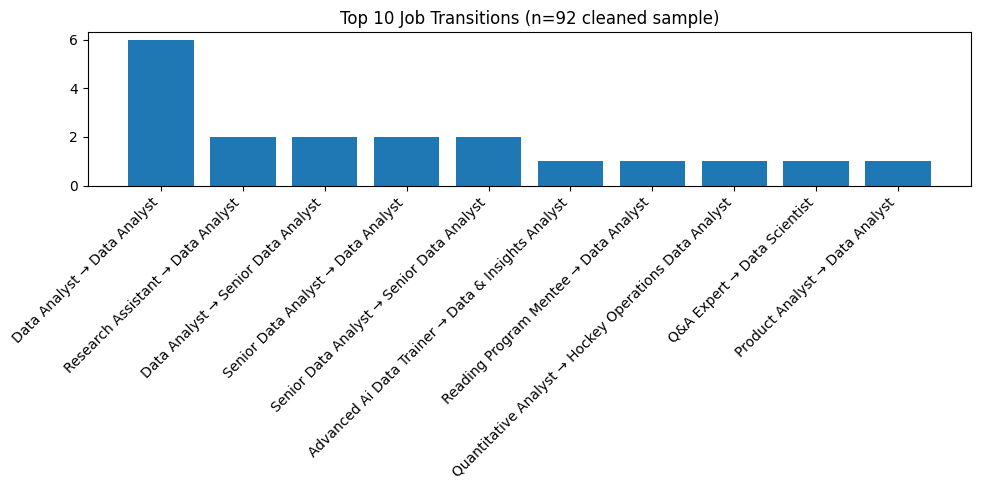

In [10]:
plot_df = top10.copy()
plot_df["transition"] = plot_df["previous_title_std"] + " → " + plot_df["current_title_std"]

plt.figure(figsize=(10,5))
plt.bar(plot_df["transition"], plot_df["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Job Transitions (n=92 cleaned sample)")
plt.tight_layout()
plt.savefig("top_transitions.png", dpi=200)
plt.show()

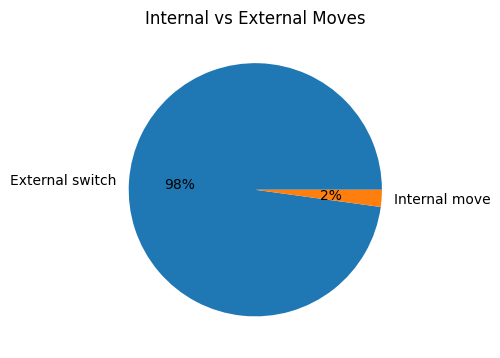

In [11]:
counts = df_clean["internal_move"].value_counts()

labels = ["External switch", "Internal move"]
values = [counts.get(False, 0), counts.get(True, 0)]

plt.figure(figsize=(5,5))
plt.pie(values, labels=labels, autopct="%1.0f%%")
plt.title("Internal vs External Moves")
plt.tight_layout()
plt.savefig("internal_vs_external.png", dpi=200)
plt.show()

## 8. Transition Matrix

A cross-tabulated transition matrix is built to model the flow between 
previous and current standardized roles.

In [12]:
transition_matrix = pd.crosstab(
    df_clean["previous_title_std"],
    df_clean["current_title_std"]
)

transition_matrix

current_title_std,Ai Data Annotation Specialist,Ai Software Developer,Analyst,Business Analyst,Business Analyst - It Group Functions,Business Analyst Intern,Business Analyst Student,Business Data Analyst,Business Intelligence Analyst,Customer Data Analyst,Data & Insights Analyst,Data Analyst,Data Analyst - Risk & Reporting,Data Analyst Intern,Data Analyst Manager,Data Consultant,Data Management Analyst,Data Research Analyst,Data Science Analyst,Data Scientist,Data Scientist - Data Analyst,Enterprise Analyst,Financial Data Analyst,Financiel Planning Analyst,Hockey Operations Data Analyst,Industrial Engineering Intern,It Data Analyst,It Support Analyst Intern,Lead Data Analyst,Medical Economics Data Analyst,Population Health Data Analyst,Principal Data Analyst,Sales & Revenue Systems Analyst,Sales Analyst Intern,Senior Analyst,Senior Data Analyst,Supply Chain Analyst
previous_title_std,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Advanced Ai Data Trainer,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Audio Editor,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Big Data Analyst,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Business Analyst,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Business Analyst Intern,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Supply Chain Analyst,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Teaching Assistant,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Technical Product Marketing Manager,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
top_prev = df_clean["previous_title_std"].value_counts().head(8).index

top_curr = df_clean["current_title_std"].value_counts().head(8).index

transition_matrix_reduced = pd.crosstab(
    df_clean[df_clean["previous_title_std"].isin(top_prev)]["previous_title_std"],
    df_clean[df_clean["current_title_std"].isin(top_curr)]["current_title_std"]
)

transition_matrix_reduced

current_title_std,Business Analyst,Business Analyst Intern,Business Data Analyst,Data Analyst,Senior Analyst,Senior Data Analyst
previous_title_std,,,,,,
Business Intelligence Engineer,0,0,0,0,0,1
Data Analyst,1,0,1,6,1,2
Logistics Processor,0,1,0,0,0,0
Manufacturing Engineer,0,0,0,1,0,0
Research Assistant,0,0,0,2,0,0
Senior Data Analyst,0,0,0,2,0,2
Senior Financial Analyst,0,0,0,1,0,0
Technical System Analyst,0,0,0,0,1,0


In [14]:
transition_matrix_reduced = transition_matrix_reduced.loc[
    transition_matrix_reduced.sum(axis=1).sort_values(ascending=False).index
]

### 8.1 Heatmap Visualization

A heatmap is used to highlight concentration of transitions across top roles.

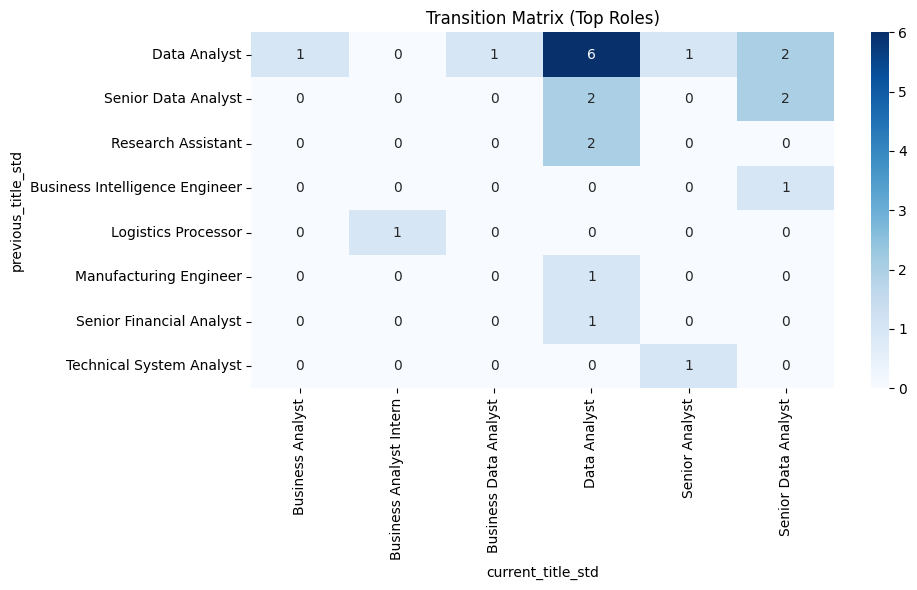

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(
    transition_matrix_reduced,
    annot=True,
    fmt="d",
    cmap="Blues"
)

plt.title("Transition Matrix (Top Roles)")
plt.tight_layout()
plt.savefig("transition_matrix_heatmap.png", dpi=200)
plt.show()

**Transition Concentration**

- Data Analyst acts as central transition node.
- Lateral transitions dominate over upward progression.
- Entry flows originate from adjacent analytical roles.

## 9. Sankey Diagram — Flow Visualization

An interactive Sankey diagram visualizes directional flow between roles, 
illustrating structural mobility within Data Analytics.

In [16]:
sankey_df = transitions.head(12).copy()

all_nodes = pd.Index(
    sankey_df["previous_title_std"].tolist() +
    sankey_df["current_title_std"].tolist()
).unique()

node_map = {name: i for i, name in enumerate(all_nodes)}

source = sankey_df["previous_title_std"].map(node_map).tolist()
target = sankey_df["current_title_std"].map(node_map).tolist()
value  = sankey_df["count"].tolist()

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=all_nodes.tolist(),
        pad=20,
        thickness=18
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(
    title_text="Top Role Transitions — Data Analytics (Top 12)",
    font_size=12
)

fig.write_html("sankey_transitions.html")
fig.show()

**Flow Interpretation**

The Sankey diagram reinforces the structural dominance of lateral mobility 
and highlights limited internal progression.

## 10. Key Insights

1. External mobility dominates (≈98%).
2. Lateral transitions (Data Analyst → Data Analyst) are most common.
3. Promotions to Senior Data Analyst occur but are secondary.
4. The market shows high fluidity and low firm-level lock-in.
5. Data Analytics roles appear structurally reversible and externally driven.